Land Use classification
with PyTorch and Fastai

### TODO:
**1. Docker container "dockerfile" Pytorch for GPU**    
    1.1 https://github.com/fastai/docker-containers#fastai  
        - "docker run --gpus all -v $PWD:/home/fastai-user -p 8888:8888 fastdotai/fastai ./run_jupyter.sh"  
        - "docker run --gpus 1 fastdotai/fastai python -c "import torch;print(torch.cuda.is_available())"  
    1.2 CNN PyTorch ntb https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb   
    1.3 ResNet https://github.com/fastai/fastbook/blob/master/14_resnet.ipynb    
    1.4 Learning source FASTAI: https://course.fast.ai/  
- - -   
**2. Natrenovat a verifikovat model na train datech**    
    2.1. Dataset - allready have one
        download: na stránce http://madm.dfki.de/downloads hledej a stáhni EuroSAT RGB a EuroSAT all 13bands
    2.2 Model
        https://github.com/shakasom/Deep-Learning-for-Satellite-Imagery/blob/master/LULC_Final.ipynb  
- - -   
**3. Aplikujeme na nas obrazek**   
    Cely proces v serii notebooku
    https://github.com/wri/UrbanLandUse/blob/master/archive/phase_iv/final/core_acquire-imagery.ipynb  
    3.1 descarteslab stahne z api obrazek  
    3.2 Zpracujeme obrazek - odkaz  
- - -  
**4. Stahnout primo ze sentinelu, vzrobit cloudless mozaic and cutting**  

Semantic segmentation>

A. Fastai UNET
https://course19.fast.ai/videos/?lesson=7
https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid-tiramisu.ipynb

B. Land Use clasification
https://medium.com/sentinel-hub/land-cover-classification-with-eo-learn-part-1-2471e8098195

C. Prepare data
https://medium.datadriveninvestor.com/preparing-aerial-imagery-for-crop-classification-ce05d3601c68

C. Semantic segmentation GITHUB
https://github.com/search?q=satellite+semantic+segmentation

Pipeline:
    Stahnout RAW data se sentinelu (13x 1band raster) (py nebo rucne)
    - rozliseni 10m/1px -> parametrizovatelne
    Udelat 4band raster R G B NIR (py - rasterio)
    Orezat dle AOI (area of interest) (Py - rasterio.mask)
    Rozrezat na kosty 500 x 500
    
    RUIAN raw data export geometrii z DB rovnou s reprojekci (rucne GIS)
    Rasterizovat (Py - rasterio)
    Orezat dle AOI (Py - rasterio.mask)
    Rozrezat na kosty 500 x 500
    
    Vztvorit model (Py)
    Natrenovat model
    Overit model
    

In [1]:
%matplotlib inline

In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from nbdev.showdoc import *
from pathlib import PosixPath

In [3]:
path = PosixPath('/workspace/fastcore')

In [4]:
path_lbl = path/'ruian_tiles'
path_img = path/'sentinel_tiles'

In [5]:
files = !ls ./sentinel_tiles
for i in files:
    print(i)

tile_0-A.tif
tile_0-B.tif
tile_0-C.tif
tile_0-D.tif
tile_0-E.tif
tile_0-F.tif
tile_0-G.tif
tile_0-H.tif
tile_0-I.tif
tile_0-J.tif
tile_0-K.tif
tile_1-A.tif
tile_1-B.tif
tile_1-C.tif
tile_1-D.tif
tile_1-E.tif
tile_1-F.tif
tile_1-G.tif
tile_1-H.tif
tile_1-I.tif
tile_1-J.tif
tile_1-K.tif
tile_2-A.tif
tile_2-B.tif
tile_2-C.tif
tile_2-D.tif
tile_2-E.tif
tile_2-F.tif
tile_2-G.tif
tile_2-H.tif
tile_2-I.tif
tile_2-J.tif
tile_2-K.tif
tile_3-A.tif
tile_3-B.tif
tile_3-C.tif
tile_3-D.tif
tile_3-E.tif
tile_3-F.tif
tile_3-G.tif
tile_3-H.tif
tile_3-I.tif
tile_3-J.tif
tile_3-K.tif
tile_4-A.tif
tile_4-B.tif
tile_4-C.tif
tile_4-D.tif
tile_4-E.tif
tile_4-F.tif
tile_4-G.tif
tile_4-H.tif
tile_4-I.tif
tile_4-J.tif
tile_4-K.tif
tile_5-A.tif
tile_5-B.tif
tile_5-C.tif
tile_5-D.tif
tile_5-E.tif
tile_5-F.tif
tile_5-G.tif
tile_5-H.tif
tile_5-I.tif
tile_5-J.tif
tile_5-K.tif
tile_6-A.tif
tile_6-B.tif
tile_6-C.tif
tile_6-D.tif
tile_6-E.tif
tile_6-F.tif
tile_6-G.tif
tile_6-H.tif
tile_6-I.tif
tile_6-J.tif
tile_6-K.tif

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

(#3) [Path('/workspace/fastcore/sentinel_tiles/tile_7-I.tif'),Path('/workspace/fastcore/sentinel_tiles/tile_7-A.tif'),Path('/workspace/fastcore/sentinel_tiles/tile_6-F.tif')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('/workspace/fastcore/ruian_tiles/tile_7-I.tif'),Path('/workspace/fastcore/ruian_tiles/tile_7-A.tif'),Path('/workspace/fastcore/ruian_tiles/tile_6-F.tif')]

<AxesSubplot:>

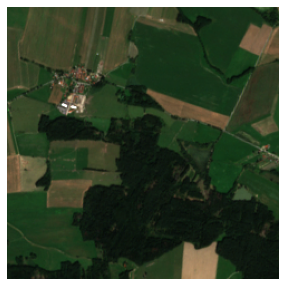

In [8]:
img_f = fnames[0]
img = PILImage.create(img_f)
img.show(figsize=(5,5))

In [9]:
# Napoveda:
#     https://github.com/hiromis/notes/blob/master/Lesson3.md
#     https://docs.python.org/3/library/pathlib.html?highlight=stem#pathlib.PurePath.stem
#     https://forums.fast.ai/t/question-on-get-y-fn/48638

# get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
get_y_fn = lambda x: path_lbl/f'{x.stem}.tif'

<AxesSubplot:>

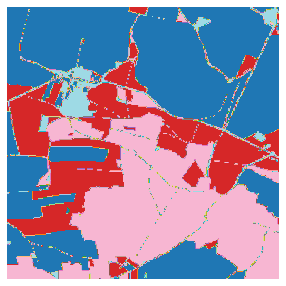

In [10]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,tensor(mask)

(array([244]),
 tensor([[1, 1, 1,  ..., 4, 1, 1],
         [1, 1, 1,  ..., 4, 1, 1],
         [1, 1, 1,  ..., 4, 4, 1],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]], dtype=torch.uint8))

In [12]:
codes = np.loadtxt('codes.txt', dtype=str); codes

array(['ocean', 'ocean', 'orná_půda', 'chmelnice', 'vinice', 'zahrada',
       'ovocný_sad', 'trvalý_travní_porost', 'trvalý_travní_porost',
       'barren', 'lesní_pozemek', 'vodní_plocha', 'nuclear_plant',
       'zastavěná_plocha_a_nádvoří', 'ostatní_plocha'], dtype='<U26')

In [13]:
len(codes)

15

## Datasets

In [14]:
size = src_size//2
bs=4

In [15]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [16]:
# export
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [17]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=lambda o: path_lbl/f'{o.stem}.tif',
                   batch_tfms=[*aug_transforms(size=(244,244)), Normalize.from_stats(*imagenet_stats)])

In [18]:
dls = camvid.dataloaders(path/"sentinel_tiles", bs=bs, path=path)

<AxesSubplot:>

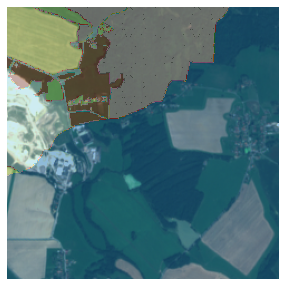

In [19]:
show_at(dls.train_ds, 11)

In [20]:
b = dls.train.one_batch()

In [21]:
b = dls.train.decode(b)

In [22]:
b[0].shape, b[1].shape

(torch.Size([4, 3, 244, 244]), torch.Size([4, 244, 244]))

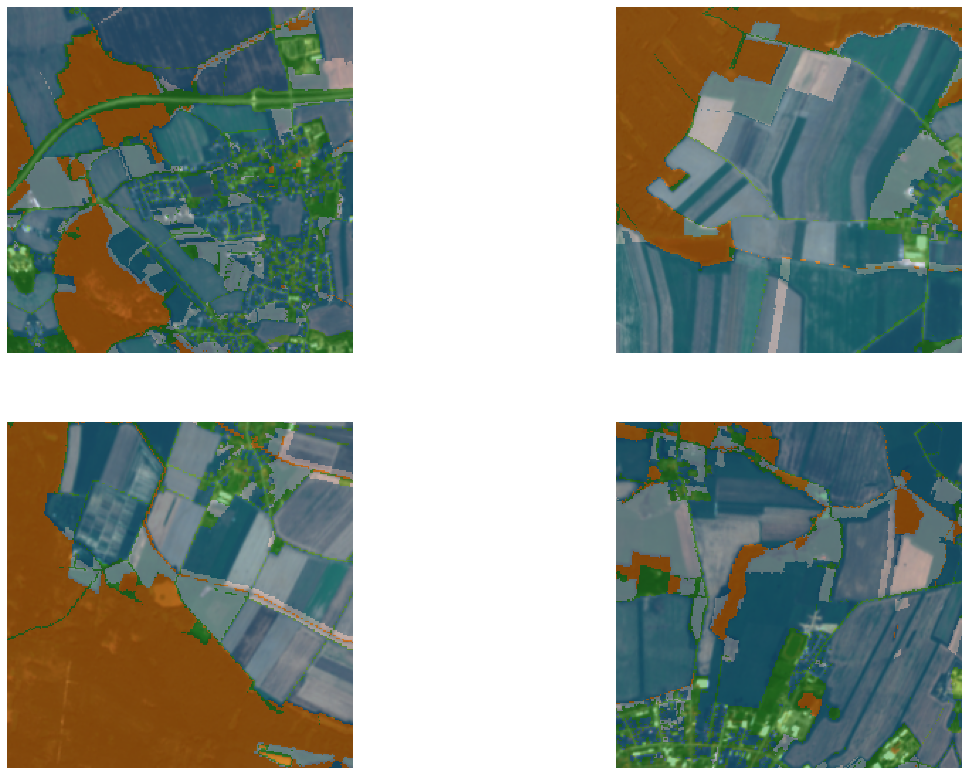

In [23]:
dls.show_batch(max_n=4, figsize=(20,14))

## Model

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['ocean']

# accuracy explained
# https://youtu.be/MpZxV6DVsmM?list=PL--LWTCopFSfXhKo1ZDKgSCjFns9jszs5&t=4427
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# => learn basic math operations in pytorch

In [25]:
metrics=acc_camvid
# metrics=accuracy

In [26]:
# weight deacay
# https://www.fast.ai/2018/07/02/adam-weight-decay/

wd=1e-2

In [27]:
dls.vocab = codes

In [28]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [29]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0004786300996784121)

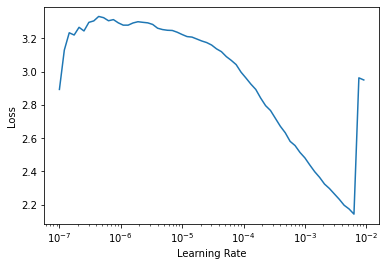

In [30]:
learn.lr_find()

In [35]:
lr=5e-4

In [36]:
# https://youtu.be/MpZxV6DVsmM?list=PL--LWTCopFSfXhKo1ZDKgSCjFns9jszs5&t=4507

# if your training loss is greater than your validation loss = you r under-fitting
# you want your traning-loss to be lower than your validation-loss
    
    # train for longer
    # lower learning rate
    
    # if still so: decrease regularization [DUNO WIT]




learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.857709,0.820847,0.641494,00:03
1,0.845697,0.814609,0.697988,00:03
2,0.860112,0.812358,0.722181,00:03
3,0.861474,0.813998,0.697802,00:03
4,0.852429,0.797723,0.727908,00:03
5,0.853578,0.859537,0.751139,00:03
6,0.858379,1.016153,0.467855,00:03
7,0.865056,0.897087,0.744666,00:03
8,0.865298,0.791013,0.612551,00:03
9,0.878782,0.812159,0.768411,00:03


In [37]:
learn.save('stage-1')

Path('/workspace/fastcore/models/stage-1.pth')

In [38]:
learn.load('stage-1')

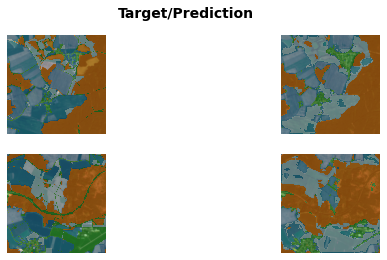

In [39]:
learn.show_results(max_n=4, figsize=(9,4))

In [40]:
learn.unfreeze()

In [41]:
lrs = slice(lr/400,lr/4)

In [42]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.861453,0.804823,0.739787,00:03
1,0.850203,0.797632,0.692108,00:03
2,0.842474,0.786786,0.671009,00:03
3,0.839327,0.785124,0.728870,00:03
4,0.835570,0.787913,0.745713,00:03
5,0.830384,0.779135,0.720044,00:03
6,0.831845,0.795875,0.752425,00:03
7,0.833540,0.782791,0.730652,00:04
8,0.827441,0.785689,0.750608,00:04
9,0.824427,0.792960,0.751127,00:04


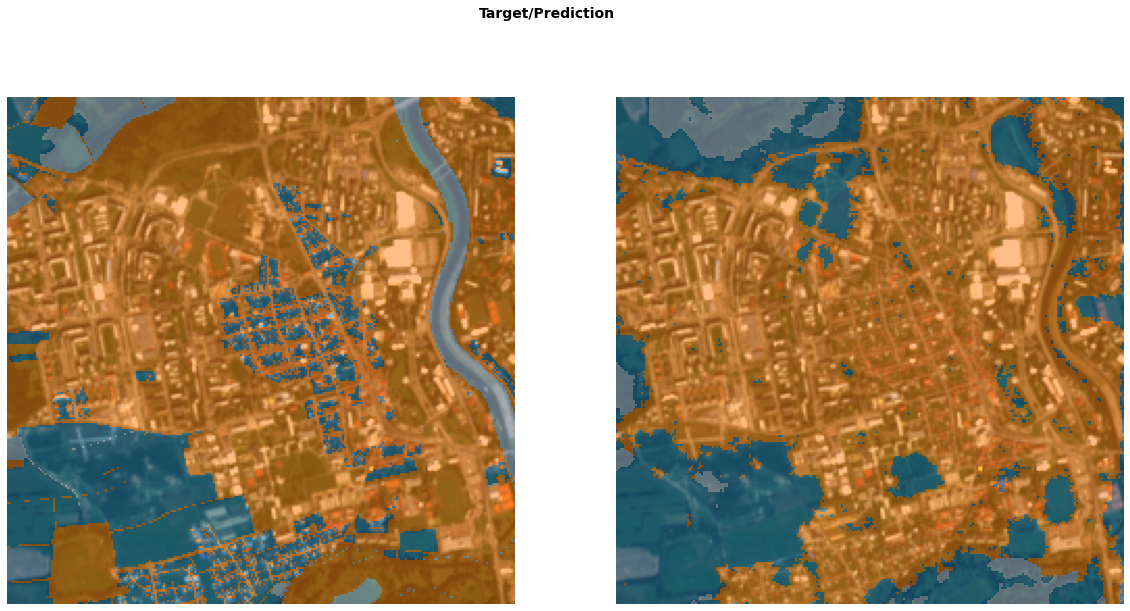

In [43]:
learn.show_results(max_n=2, figsize=(20,10), vmin=1, vmax=30)

In [44]:
learn.save('stage-2')

Path('/workspace/fastcore/models/stage-2.pth')

In [45]:
del learn
import gc
gc.collect()

13850

In [46]:
size = src_size
bs=3

In [48]:
dls = camvid.dataloaders(path/"sentinel_tiles", bs=3, path=path,
                          batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

In [49]:
dls.vocab = codes

In [50]:
learn = unet_learner(dls, resnet34, metrics=metrics)

In [51]:
learn.load('stage-2')

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=6.309573450380412e-07)

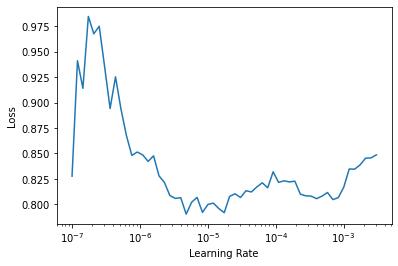

In [52]:
learn.lr_find()

In [53]:
lr=1e-6

In [54]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.856793,0.789471,0.687306,00:04
1,0.823592,0.782154,0.696057,00:03
2,0.818384,0.767623,0.703707,00:03
3,0.828001,0.786461,0.688412,00:03
4,0.817548,0.792090,0.693464,00:03
5,0.816682,0.776238,0.706649,00:03
6,0.807526,0.773866,0.708967,00:03
7,0.805666,0.764859,0.719273,00:03
8,0.803523,0.766973,0.721254,00:03
9,0.796362,0.773448,0.721377,00:03


In [55]:
learn.save('stage-1-big')

Path('/workspace/fastcore/models/stage-1-big.pth')

In [56]:
learn.load('stage-1-big')

In [57]:
learn.unfreeze()

In [58]:
lrs = slice(1e-6,lr/10)

In [59]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.821766,0.772820,0.719549,00:04
1,0.808110,0.774729,0.705666,00:04
2,0.791761,0.784414,0.717362,00:04
3,0.792409,0.771511,0.722430,00:04
4,0.801012,0.776722,0.714876,00:04
5,0.800925,0.773436,0.717811,00:04
6,0.795284,0.789062,0.705863,00:04
7,0.795775,0.768322,0.718890,00:04
8,0.791987,0.767753,0.719488,00:04
9,0.797743,0.763626,0.725432,00:04


In [60]:
learn.save('stage-2-big')

Path('/workspace/fastcore/models/stage-2-big.pth')

In [61]:
learn.load('stage-2-big')

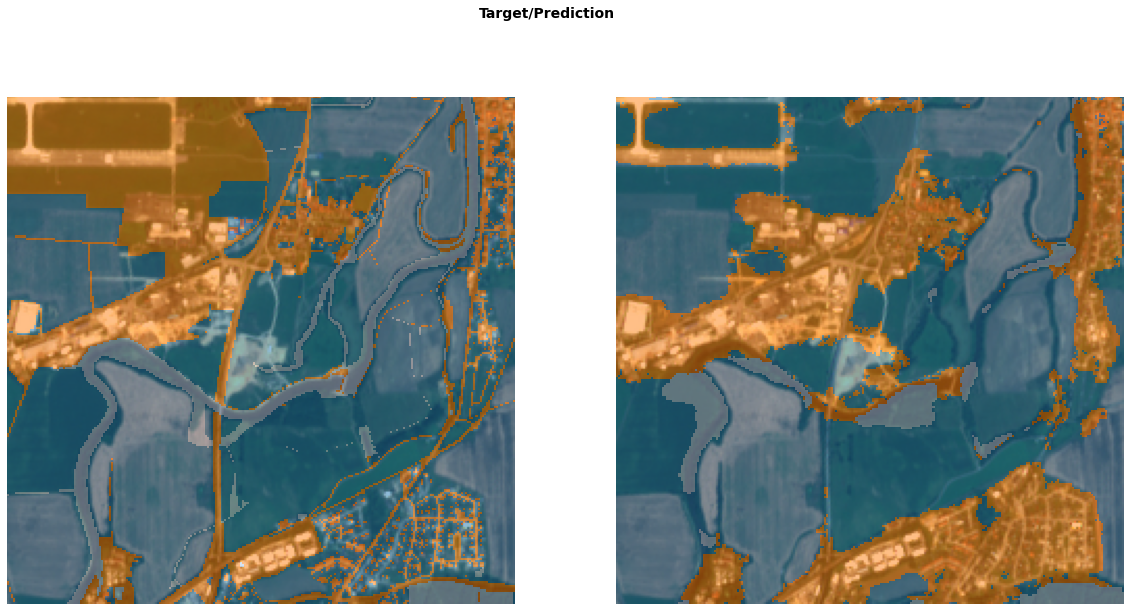

In [64]:
learn.show_results(max_n=3, figsize=(20,10), vmin=1, vmax=30)